# Assignment 2
Welcome to the second NNFL assignment. Please read the instructions given below carefully before attempting the assignment.  
- Do NOT import any other modules or functions
- Do NOT change the prototypes of any of the functions
- Do NOT change code outside of the allowed areas
- Sample test cases are already given, test your code using these sample cases
- Grading will be based on hidden test cases
- Please solve this notebook using [Google Colab](https://colab.research.google.com/) as the required packages are already installed 

In [1]:
#DO NOT IMPORT ANY OTHER LIBRARY
#Run these cells as it is
import tensorflow as tf
import numpy as np
import csv
import pandas as pd
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


IMPORTING DATASET

In [2]:
!git clone https://github.com/BITS-NNFL/Coronavirus-Tweets-Dataset.git 

Cloning into 'Coronavirus-Tweets-Dataset'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 7 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (7/7), done.


In [3]:
%cd /content/Coronavirus-Tweets-Dataset

/content/Coronavirus-Tweets-Dataset


## Part 1 - Data Processing
Let's first read the csv files for train and test into Pandas DataFrames. 
 - Fill in your code for data loading using a Pandas function.
 - Retrieve only the columns of **OriginalTweet and Sentiment** while you read the csv into a pandas dataframe
 - Specify the encoding **latin1** while you read the csv into a pandas dataframe

In [4]:
#GRADED - 0.25 MARKS
def load_dataframe(filename):
    """
    Args:
        'filename': filename of csv to be loaded
    Returns:
        'df': Pandas DataFrame with appropriate csv loaded
    """
    # YOUR CODE HERE
    df = pd.read_csv(filename, encoding='latin1', usecols=['OriginalTweet','Sentiment']) 
    return df
    raise NotImplementedError()

In [5]:
# Sample test cases
train = load_dataframe('Corona_NLP_train.csv')
test = load_dataframe('Corona_NLP_test.csv')
assert train.shape==(41157, 2)
assert test.shape==((3798, 2))
print('Sample Test passed', '\U0001F44D')

Sample Test passed 👍


In [6]:
# hidden test cases. Do not modify

In [7]:
#Analyzing the dataframe
train.describe()

,OriginalTweet,Sentiment
count,41157,41157
unique,41157,5
top,As the world battles we re joining other patie...,Positive
freq,1,11422


Here you can see that we have a count of over 40,000 unique tweets as samples in our dataset. Associated with each of these tweets are 5 unique values signifying their sentiment. Let us see what these values are:

In [8]:
train['Sentiment'].unique()

array(['Neutral', 'Positive', 'Extremely Negative', 'Negative',
       'Extremely Positive'], dtype=object)

So we have a range of five sentiments describing the tweet ranging from Extremely Negative to Extremely Positive. We find the distinct sentiments of Extremely positive and positive (and Extremely negative and negative) perfunctory and somewhat subjective. Hence, we will transorm our 5-way classification problem into a 3-way problem. 
 - "Extremely Negative" and "Extremely Positive" values are changed to "Negative" and "Positive" values respectively
 - The other values (Positive, Neutral and Negative) are unchanged.
 - Hint: Mapping can be done using the Pandas map function on the Sentiment column

In [9]:
#GRADED - 0.5 MARKS
def sentiment_map(df):
    """
    Args:
        'df': Pandas DataFrame
    Returns:
        'df': Pandas DataFrame with Sentiment column with the new mapping as described
    """
    # YOUR CODE HERE
    mapping = {"Extremely Negative": "Negative", 'Extremely Positive': 'Positive', 'Positive': 'Positive', 'Negative': 'Negative', 'Neutral':'Neutral'}
    df['Sentiment'] = df['Sentiment'].map(mapping)
    return df
    raise NotImplementedError()

In [10]:
# Sample test cases
train = sentiment_map(train)
test = sentiment_map(test)
assert sorted(train.Sentiment.unique())==['Negative', 'Neutral', 'Positive']
assert sorted(test.Sentiment.unique())==['Negative', 'Neutral', 'Positive']
print('Sample Test passed', '\U0001F44D')

Sample Test passed 👍


In [11]:
# hidden test cases. Do not modify

In [12]:
#Verifying our changes
train.describe()

,OriginalTweet,Sentiment
count,41157,41157
unique,41157,3
top,As the world battles we re joining other patie...,Positive
freq,1,18046


In [13]:
#And for test dataframe
test.describe()

,OriginalTweet,Sentiment
count,3798,3798
unique,3798,3
top,"Germany has actually created, or at least it's...",Negative
freq,1,1633


In [14]:
#Checking for any null values in the columns we have chosen. These can be problematic, and must be resolved if present
train.isnull().sum()

OriginalTweet    0
Sentiment        0
dtype: int64

Great! We have no null values present. Let's carry out a bit of fun Exploratory Data Analysis to better understand our dataset

# Exploratory Data Analysis

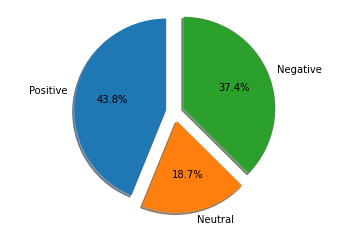

In [15]:
vals = [len(train[train['Sentiment']=='Positive']['Sentiment']), len(train[train['Sentiment']=='Neutral']['Sentiment']), len(train[train['Sentiment']=='Negative']['Sentiment'])]
idx = ['Positive', 'Neutral', 'Negative']
explode = (0.1, 0.1, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(vals, explode=explode, labels=idx, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

We can notice that our training dataset has over 40% of positive tweets, just under 40% of negative tweets, and just under 20% of neutral tweets. Next, let's formulate basic word clouds for our training dataframe tweets

## Word Clouds

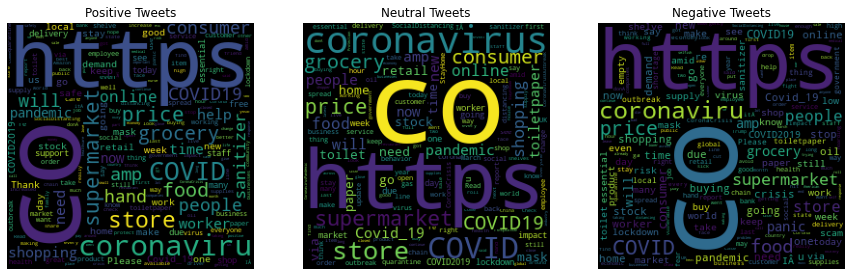

In [16]:
positive = " ".join(train[train['Sentiment'] == 'Positive']['OriginalTweet'].to_list())
neutral = " ".join(train[train['Sentiment'] == 'Neutral']['OriginalTweet'].to_list())
negative = " ".join(train[train['Sentiment'] == 'Negative']['OriginalTweet'].to_list())

fig, ax = plt.subplots(1, 3, figsize=(15,15))
pos_cloud = WordCloud(width=256, height=256, collocations=False).generate(positive)
neut_cloud = WordCloud(width=256, height=256, collocations=False).generate(neutral)
neg_cloud = WordCloud(width=256, height=256, collocations=False).generate(negative)
clouds = [pos_cloud, neut_cloud, neg_cloud]
titls = ["Positive Tweets", "Neutral Tweets", "Negative Tweets"]

for no, x in enumerate(clouds):
    ax[no].imshow(x)
    ax[no].axis('off')
    ax[no].set_title(titls[no])

Notice that "https" is a very prominent string among all kinds of tweets in our dataset, which means that a LOT of people include links in their tweets. Note that while a prominent member of tweets, these links provide almost no usable information to us at face value in our aim of classifying these tweets as positive, neutral or negative. Next, let's focus on cleaning our dataset and removing unnecessary characters from our tweets that is a form of noise we want to remove. Basically, let's form a sleeker version of our dataset that contains only what we want.
Let's inspect our first sample, which coincidentally serves as a good example of what we DON'T want:

In [17]:
train.iloc[0]['OriginalTweet']

'@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8'

## Cleaning
Note that symbols like '@', ':', '/','.' serve no purpose in our aim of classifying sentiment. Let's also look at stopwords. Stopwords are words of the language that are generally filtered out during the text preprocessing stage. These include but are not limited to prepositions, articles, conjunctions and pronouns.

For the following functions that involve removal of certain patterns, use [Regular Expressions](https://www.w3schools.com/python/python_regex.asp#sub)
 - Patterns can be compiled using [prog = re.compile(pattern)](https://docs.python.org/3/library/re.html#re.compile)
 - Patterns can be substituted using sub; example: result = prog.sub(replacement text, text to search in)
 
 For the following remove_urls function, remove remove links starting with https:// and www. (remove the entire link including the prefix)

In [18]:
#GRADED - 0.25 MARKS
def remove_urls(text):
    """
    Args:
        'text': string containing tweet 
    Returns:
        'text_processed': string with URLs removed (remove links starting with https:// and www.)
    """
    # YOUR CODE HERE
    prog = re.compile(r'https?:\/\/\S+|www\.\S+')
    text_processed =  prog.sub(r'', text)
    return text_processed
    raise NotImplementedError()

In [19]:
# Sample test cases
assert remove_urls(train.iloc[0]['OriginalTweet'])=='@MeNyrbie @Phil_Gahan @Chrisitv  and  and '
print('Sample Test passed', '\U0001F44D')

Sample Test passed 👍


In [20]:
# hidden test cases. Do not modify

For the following function convert the text to lowercase (regex need not be used)

In [21]:
#GRADED - 0.25 MARKS
def lower(text):
    """
    Args:
        'text': string containing tweet 
    Returns:
        'text_processed': lowercase converted string 
    """
    # YOUR CODE HERE
    text_processed = text.lower()
    return text_processed
    raise NotImplementedError()

In [22]:
# Sample test cases
assert lower(train.iloc[35]['OriginalTweet'])=='went to the supermarket yesterday and the toilet paper was gone. has this anything to do with the corona virus? #covid2019'
print('Sample Test passed', '\U0001F44D')

Sample Test passed 👍


In [23]:
# hidden test cases. Do not modify

For the following function, use regex to remove numbers.
 - This can be done by using [re.sub](https://docs.python.org/3/library/re.html#re.sub), i.e. substituting numbers with blanks.

In [24]:
#GRADED - 0.25 MARKS
def remove_num(text):
    """
    Args:
        'text': string containing tweet 
    Returns:
        'text_processed': corresponding string with numbers removed
    """
    # YOUR CODE HERE
    text_processed = re.sub(r'\d+', '', text)
    return text_processed
    raise NotImplementedError()

In [25]:
# Sample test cases
assert remove_num(train.iloc[46]['OriginalTweet'])==' Please Share  Know someone who s  Living on their own struggling to get  their local supermarket due to issues around  We re offering FREE deliveries of our healthy soups NATIONWIDE to anyone  in need Plus their freezable'
print('Sample Test passed', '\U0001F44D')

Sample Test passed 👍


In [26]:
# hidden test cases. Do not modify

For the following function use regex to remove punctuation.
 - This can be done by using [re.sub](https://docs.python.org/3/library/re.html#re.sub), i.e. substituting punctuation(using [special sequences](https://www.w3schools.com/python/python_regex.asp)) with blanks. 

In [27]:
#GRADED - 0.5 MARKS
def remove_punc(text):
    """
    Args:
        'text': string containing tweet 
    Returns:
        'text_processed': corresponding string with punctuation removed using regex
    """
    # YOUR CODE HERE
    text_processed = re.sub(r"[^\w\s\d]","", text)
    return text_processed
    raise NotImplementedError()

In [28]:
# Sample test cases
assert remove_punc(test.iloc[1]['OriginalTweet'])=='When I couldnt find hand sanitizer at Fred Meyer I turned to Amazon But 11497 for a 2 pack of PurellCheck out how  coronavirus concerns are driving up prices httpstcoygbipBflMY'
assert remove_punc(train.iloc[0]['OriginalTweet'])=='MeNyrbie Phil_Gahan Chrisitv httpstcoiFz9FAn2Pa and httpstcoxX6ghGFzCC and httpstcoI2NlzdxNo8'
print('Sample Test passed', '\U0001F44D')

Sample Test passed 👍


In [29]:
# hidden test cases. Do not modify

In [30]:
stops = stopwords.words("english")

For the following function remove the stopwords from the cell above in the text. Regex need not be used; this can be done with string functions

In [31]:
#GRADED - 0.25 MARKS 
def remove_stopwords(text):
    """
    Args:
        'text': string containing tweet 
    Returns:
        'text_processed': corresponding string with stopwords removed
    """    
    # YOUR CODE HERE
    return " ".join([word for word in str(text).split() if word not in stops])
    raise NotImplementedError()

In [32]:
# Sample test cases
assert remove_stopwords(test.iloc[100]['OriginalTweet'])=='@NileshShah68 I summarized important points paper thread: https://t.co/dTZg4vg8VM'
print('Sample Test passed', '\U0001F44D')

Sample Test passed 👍


In [33]:
# hidden test cases. Do not modify

For the following function, remove extra white space
 - Extra spaces within text can be removed using regex
 - Leading and trailing spaces can be removed with a python function

In [34]:
#GRADED - 0.25 MARKS
def remove_space(text):
    """
    Args:
        'text': string containing tweet 
    Returns:
        'text_processed': corresponding string with extra white space removed
    """ 
    # YOUR CODE HERE
    space_remove = re.sub(r"\s+"," ",text).strip()
    return space_remove
    raise NotImplementedError()

In [35]:
# Sample test cases
assert remove_space('  Sample test  case   ')=='Sample test case'
print('Sample Test passed', '\U0001F44D')

Sample Test passed 👍


In [36]:
# hidden test cases. Do not modify

Finally, the clean_text function will apply all the previously created functions
 - Apply the the previous cleaning functions in that order (remove_urls(),lower(),remove_num(),remove_punc(),remove_stopwords(),remove_space()) to the OriginalTweet column
 - This can be done with the [Pandas function](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html) with **lambda** for each of the cleaning functions on the 'OriginalTweet' column

In [37]:
#GRADED - 0.5 MARKS
def clean_text(data):
    """
    Args:
        'data': Pandas dataframe
    Returns:
        'data': cleaned dataframe with the prior functions (remove_urls(),lower(),remove_num(),remove_punc(),remove_stopwords(),remove_space()) applied to the OriginalTweet column
    """ 
    # YOUR CODE HERE
    data['OriginalTweet']=data['OriginalTweet'].apply(lambda x:remove_urls(x))
    data['OriginalTweet']=data['OriginalTweet'].apply(lambda x:lower(x))
    data['OriginalTweet']=data['OriginalTweet'].apply(lambda x:remove_num(x))
    data['OriginalTweet']=data['OriginalTweet'].apply(lambda x:remove_punc(x))
    data['OriginalTweet']=data['OriginalTweet'].apply(lambda x:remove_stopwords(x))
    data['OriginalTweet']=data['OriginalTweet'].apply(lambda x:remove_space(x))
    return data
    raise NotImplementedError()

In [38]:
# Sample test cases
train_cleaned = clean_text(train)
test_cleaned = clean_text(test)
assert train_cleaned.iloc[4]['OriginalTweet']=='ready go supermarket covid outbreak im paranoid food stock litteraly empty coronavirus serious thing please dont panic causes shortage coronavirusfrance restezchezvous stayathome confinement'
assert test_cleaned.iloc[2]['OriginalTweet']=='find protect loved ones coronavirus'
print('Sample Test passed', '\U0001F44D')

Sample Test passed 👍


In [39]:
# hidden test cases. Do not modify


Amazing! We have really cleaned our data up and kept only that which is of importance to us and removing all noise. Now, let's revisualize our word clouds. These should be more representative of the meanings that the tweets actually capture.

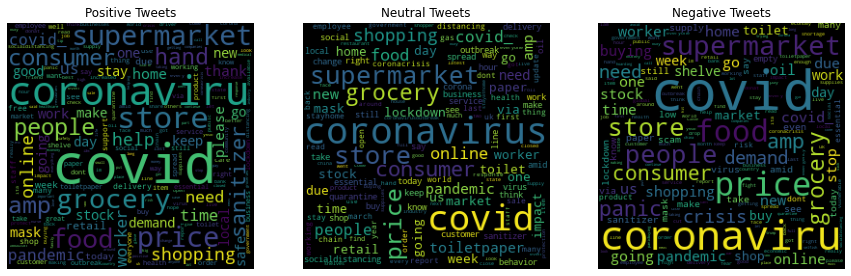

In [40]:
positive = " ".join(train[train['Sentiment'] == 'Positive']['OriginalTweet'].to_list())
neutral = " ".join(train[train['Sentiment'] == 'Neutral']['OriginalTweet'].to_list())
negative = " ".join(train[train['Sentiment'] == 'Negative']['OriginalTweet'].to_list())

fig, ax = plt.subplots(1, 3, figsize=(15,15))
pos_cloud = WordCloud(width=256, height=256, collocations=False).generate(positive)
neut_cloud = WordCloud(width=256, height=256, collocations=False).generate(neutral)
neg_cloud = WordCloud(width=256, height=256, collocations=False).generate(negative)
clouds = [pos_cloud, neut_cloud, neg_cloud]
titls = ["Positive Tweets", "Neutral Tweets", "Negative Tweets"]

for no, x in enumerate(clouds):
    ax[no].imshow(x)
    ax[no].axis('off')
    ax[no].set_title(titls[no])

# Tokenisation of Input

Machines aren't like humans. Our model won't understand words like we do, it needs our data in a form that is readable for it, i.e, as numbers. Let's tokenize our data to do that. For us to have tokens of words in both our training and test sets, we'll fit the tokenizer on both. 

You can read the [Documentation](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) to understand more about the tokenizer and to figure out which functions you'll need. 
Steps:
 - Create a Tokenizer object
 - Concat the OriginalTweet columns of train and test to get a Series of sentences using a Pandas function
 - **Fit on texts** i.e. Fit the tokenizer on the sentences 

In [50]:
#GRADED - 0.5 MARKS
def define_tokenizer(train,test):
    """
    Args:
        'train': train dataframe
        'test': test dataframe
    Returns:
        'tokenizer': tokenizer fitted on the concatenated train and test dataframes
        'sentences': Series of senteces obtained by concatenating the OriginalTweet columns of the dataframes
    """ 
    # YOUR CODE HERE
    frames = [train, test]
    sentences = pd.concat(frames).drop(columns = 'Sentiment')
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(sentences['OriginalTweet'])
    return tokenizer,sentences
    raise NotImplementedError()

In [51]:
# Sample test cases
tokenizer,sentences = define_tokenizer(train_cleaned,test_cleaned)
assert len(tokenizer.word_index)==62380
print('Sample Test passed', '\U0001F44D')

Sample Test passed 👍


In [ ]:
# hidden test cases. Do not modify

Now we can transform the train and test dataframes. 
 - First find train_maxlen, which is the is the length of the longest sentence in the OriginalTweet column of train. Similarly find test_maxlen.
 - Set max_length as the max of train_maxlen and test_maxlen.
 - Obtain a 2D list by converting the **text to sequences** using the tokenizer on train.
 - **Pad sequences** of the obtained list using *post* padding and maxlen as the previously calculated *max_length* which outputs an numpy array. *Check the imports at the start to see which function we can use here, and understand which of the function's parameters we need here*
 - Apply the similar process for test and return the converted dataframes.

In [56]:
#GRADED - 1 MARKS
def tokenize_dataframes(train,test,tokenizer):
    """
    Args:
        'train': train dataframe
        'test': test dataframe
        'tokenizer': the previously fitted tokenizer
    Returns:
        'max_length': maximum length obtained from either train or test sentences
        'X_train': converted 2D numpy array after text to sequence and pad sequence for training data
        'X_test': converted 2D numpy array after text to sequence and pad sequence for test data
    """ 
    # YOUR CODE HERE
    tokenizer,sentences = define_tokenizer(train,test)
    train_maxlen =  train['OriginalTweet'].map(lambda x: len(str(x))).max()
    test_maxlen =  test['OriginalTweet'].map(lambda x: len(str(x))).max()
    max_length = max(train_maxlen, test_maxlen)
    X_train = tokenizer.texts_to_sequences(train)
    X_test = tokenizer.texts_to_sequences(test)
    X_train = pad_sequences(X_train, maxlen=max_length)
    X_test = pad_sequences(X_test, maxlen=max_length)
    return max_length,X_train,X_test
    raise NotImplementedError()

In [57]:
# Sample test cases
max_length,X_train,X_test = tokenize_dataframes(train_cleaned,test_cleaned,tokenizer)
assert max_length==266
print('Sample Test passed', '\U0001F44D')

Sample Test passed 👍


In [ ]:
# hidden test cases. Do not modify

We will now obtain the labels. Since the labels (Sentiment) column are not numeric, we can map them to numbers. 
 - Convert the values of Negative in Sentiment in train and test to 0
 - Convert the values of Neutral in Sentiment in train and test to 1
 - Convert the values of Positive in Sentiment in train and test to 2
 - Return the newly converted column of train and test as Y_train and Y_test

In [60]:
#GRADED - 0.5 MARKS
def obtain_labels(train,test):
    """
    Args:
        'train': train dataframe
        'test': test dataframe
    Returns:
        'Y_train': Pandas Series of converted labels as explained above for train data
        'Y_test': Pandas Series of converted labels as explained above for test data
    """ 
    # YOUR CODE HERE
    mapval = {'Negative':0, 'Positive':2, 'Neutral':1}
    Y_train = train['Sentiment'].map(mapval)
    Y_test = test['Sentiment'].map(mapval)
    return Y_train,Y_test
    raise NotImplementedError()

In [61]:
# Sample test cases
Y_train,Y_test = obtain_labels(train,test)
assert len(Y_train)==41157
assert len(Y_test)==3798
print('Sample Test passed', '\U0001F44D')

Sample Test passed 👍


In [62]:
# hidden test cases. Do not modify

Converting labels into a binary matrix

In [63]:
Y_train = to_categorical(Y_train, 3)
Y_test  = to_categorical(Y_test, 3)

We also need to convert the given data into "float" format to be able to compute gradients for backpropagation and calculate forward tensors(/node values)

In [64]:
# Train Data to float32
X_train = np.asarray(X_train).astype('float32')
Y_train = np.asarray(Y_train).astype('float32')

# Test Data to float32
X_test = np.asarray(X_test).astype('float32')
Y_test = np.asarray(Y_test).astype('float32')

## Part 2 - Implementing LSTM

### Long-Short Term Memory (LSTM) Network

The following figure shows the operations of an LSTM-cell.

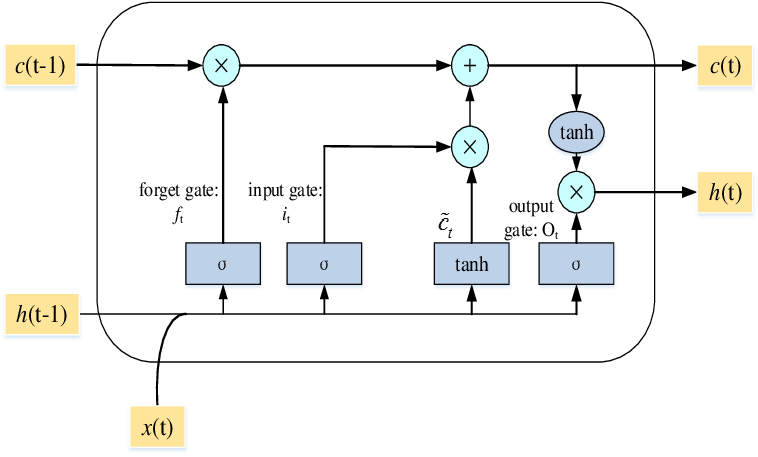





You will start by implementing the LSTM cell for a single time-step. Then you can iteratively call it from inside a "for-loop" to have it process an input with $T_x$ time-steps.

### Overview of gates and states

> **Forget gate $\mathbf{f}_{t}$**


Let's assume we are reading words in a piece of text, and plan to use an LSTM to keep track of grammatical structures, such as whether the subject is singular ("puppy") or plural ("puppies").
If the subject changes its state (from a singular word to a plural word), the memory of the previous state becomes outdated, so we "forget" that outdated state.
The "forget gate" is a tensor containing values that are between 0 and 1.
If a unit in the forget gate has a value close to 0, the LSTM will "forget" the stored state in the corresponding unit of the previous cell state.
If a unit in the forget gate has a value close to 1, the LSTM will mostly remember the corresponding value in the stored state.
Equation
$$\mathbf{f}_t = \sigma(\mathbf{W}_f[\mathbf{h}_{\langle t-1 \rangle}, \mathbf{x}_{\langle t \rangle}] + \mathbf{b}_f)\tag{1} $$


**Explanation of the equation**:

* $\mathbf{W_{f}}$ contains weights that govern the forget gate's behavior. The previous time step's hidden state $h_{\langle t-1 \rangle}$ and current time step's input $x_{\langle t \rangle}$ are concatenated together and multiplied by $\mathbf{W_{f}}$.
* A sigmoid function is used to make each of the gate tensor's values $\mathbf{f}_t$ range from 0 to 1.
* The forget gate $\mathbf{f}_t$ has the same dimensions as the previous cell state $c_{\langle t-1 \rangle}$.
* This means that the two can be multiplied together, element-wise.
Multiplying the tensors $\mathbf{f}_t * \mathbf{c}_{\langle t-1 \rangle}$ is like applying a mask over the previous cell state.
If a single value in $\mathbf{f}_t$ is 0 or close to 0, then the product is close to 0.
This keeps the information stored in the corresponding unit in $\mathbf{c}_{\langle t-1 \rangle}$ from being remembered for the next time step.
Similarly, if one value is close to 1, the product is close to the original value in the previous cell state.
The LSTM will keep the information from the corresponding unit of $\mathbf{c}_{\langle t-1 \rangle}$, to be used in the next time step.

**Variable names in the code**

The variable names in the code are similar to the equations, with slight differences.

- Wf: forget gate weight $\mathbf{W}_{f}$
- Wb: forget gate bias $\mathbf{W}_{b}$
- ft: forget gate $\mathbf{f}_t$


> **Candidate value $\tilde{\mathbf{c}}_{\langle t \rangle}$**

- The candidate value is a tensor containing information from the current time step that may be stored in the current cell state $\mathbf{c}_{\langle t \rangle}$.
- Which parts of the candidate value get passed on depends on the input gate.
- The candidate value is a tensor containing values that range from -1 to 1.
- The tilde "~" is used to differentiate the candidate $\tilde{\mathbf{c}}_{\langle t \rangle}$ from the cell state $\mathbf{c}_{\langle t \rangle}$.

**Equation**
$$\mathbf{\tilde{c}}_{\langle t \rangle} = \tanh\left( \mathbf{W}_{c} [\mathbf{h}_{\langle t - 1 \rangle}, \mathbf{x}_{\langle t \rangle}] + \mathbf{b}_{c} \right) \tag{3}$$
**Explanation of the equation**

The 'tanh' function produces values between -1 and +1.

**Variable names in the code**
- cct: candidate value $\mathbf{\tilde{c}}_{\langle t \rangle}$

> **Input gate $\mathbf{i}_t$**

- We use the input gate to decide what aspects of the candidate $\tilde{\mathbf{c}}_{\langle t \rangle}$ to add to the cell state $c_{\langle t \rangle}$.
- The input gate decides what parts of a "candidate" tensor $\tilde{\mathbf{c}}_{\langle t \rangle}$ are passed onto the cell state $\mathbf{c}_{\langle t \rangle}$.
- The input gate is a tensor containing values between 0 and 1.
When a unit in the input gate is close to 1, it allows the value of the candidate $\tilde{\mathbf{c}}_{\langle t \rangle}$ to be passed onto the hidden state $\mathbf{c}_{\langle t \rangle}$
When a unit in the input gate is close to 0, it prevents the corresponding value in the candidate from being passed onto the hidden state.
- Notice that input gate is also mentioned as update gate in the literature.

**Equation**
$$\mathbf{i}_t = \sigma(\mathbf{W}_i[h_{\langle t-1 \rangle}, \mathbf{x}_{\langle t \rangle}] + \mathbf{b}_i)\tag{2} $$
**Explanation of the equation**

- Similar to the forget gate, here $\mathbf{i}_t$, the sigmoid produces values between 0 and 1.
- The input gate is multiplied element-wise with the candidate, and this product ($\mathbf{i}_t * \tilde{c}_{\langle t \rangle}$) is used in determining the cell state $\mathbf{c}_{\langle t \rangle}$.

**Variable names in code**
(Please note that they're different than the equations)

In the code, we'll use the variable names found in the academic literature. These variables don't use "u" to denote "update".

- Wi is the input gate weight $\mathbf{W}_i$ (not "Wu")
- bi is the input gate bias $\mathbf{b}_i$ (not "bu")
- it is the input gate $\mathbf{i}_t$ (not "ut")

> **Cell state $\mathbf{c}_{\langle t \rangle}$**

- The cell state is the "memory" that gets passed onto future time steps.
- The new cell state $\mathbf{c}_{\langle t \rangle}$ is a combination of the previous cell state and the candidate value.

**Equation**
$${\mathbf{c}_{\langle t \rangle} = \mathbf{f}_t * \mathbf{c}_{\langle t-1 \rangle} + \mathbf{i}_t  * \mathbf{\tilde{c}}_{\langle t \rangle} \tag{4}} $$

**Explanation of equation**

The previous cell state $\mathbf{c}_{\langle t-1 \rangle}$ is adjusted (weighted) by the forget gate $\mathbf{f}_t$
and the candidate value $\tilde{\mathbf{c}}_{\langle t \rangle}$, adjusted (weighted) by the input gate $\mathbf{i}_t$

**Variable names and shapes in the code**
- c: cell state, including all time steps, $\mathbf{c}$ shape $(h_{shape}, m, T)$
- c_next: new (next) cell state, $\mathbf{c}_{\langle t \rangle}$ shape $(h_{shape}, m)$
- c_prev: previous cell state, $\mathbf{c}_{\langle t-1 \rangle}$, shape $(h_{shape}, m)$

> **Output gate $\mathbf{O}_t$**

- The output gate decides what gets sent as the prediction (output) of the time step.
- The output gate is like the other gates. It contains values that range from 0 to 1.

**Equation**
$$ \mathbf{O}_t=  \sigma(\mathbf{W}_o[\mathbf{h}_{\langle t-1 \rangle}, \mathbf{x}_{\langle t \rangle}] + \mathbf{b}_{o})\tag{5}$$

**Explanation of the equation**

The output gate is determined by the previous hidden state $\mathbf{h}_{\langle t-1 \rangle}$ and the current input $\mathbf{x}_{\langle t \rangle}$
The sigmoid makes the gate range from 0 to 1.

**Variable names in the code**
- Wo: output gate weight, $\mathbf{W_o}$
- bo: output gate bias, $\mathbf{b_o}$
- ot: output gate, $\mathbf{O}_t$

> **Hidden state $\mathbf{h}_{\langle t \rangle}$**

- The hidden state gets passed to the LSTM cell's next time step.
- It is used to determine the three gates ($\mathbf{f}_t, \mathbf{i}_{t}, \mathbf{O}_t$) of the next time step.
- The hidden state is also used for the prediction $y^{\langle t \rangle}$.

**Equation**
$$ \mathbf{h}^{\langle t \rangle} = \mathbf{O}_t * \tanh(\mathbf{c}_{\langle t \rangle})\tag{6} $$

**Explanation of equation**
- The hidden state $\mathbf{h}_{\langle t \rangle}$ is determined by the cell state $\mathbf{c}_{\langle t \rangle}$ in combination with the output gate $\mathbf{O}_t$.
- The cell state state is passed through the "tanh" function to rescale values between -1 and +1.
- The output gate acts like a "mask" that either preserves the values of $\tanh(\mathbf{c}_{\langle t \rangle})$ or keeps those values from being included in the hidden state $\mathbf{h}_{\langle t \rangle}$

**Variable names and shapes in the code**
- h: hidden state, including time steps. $\mathbf{h}$ has shape $(h_{shape}, m, T_{x})$
- 'hprev`: hidden state from previous time step. $\mathbf{h}_{\langle t-1 \rangle}$ has shape $(h_{shape}, m)$
- h_next: hidden state for next time step. $\mathbf{h}_{\langle t \rangle}$ has shape $(h_{shape}, m)$

> **Prediction $\mathbf{y}^{\langle t \rangle}_{pred}$**

The prediction in this use case is a classification, so we'll use a softmax.
The equation is:$$\mathbf{y}^{\langle t \rangle}_{pred} = \textrm{softmax}(\mathbf{W}_{y} \mathbf{h}_{\langle t \rangle} + \mathbf{b}_{y})$$

**Variable names and shapes in the code**

- y_pred: prediction, including all time steps. $\mathbf{y}_{pred}$ has shape $(y_{shape}, m, T_{x})$. Note that $(T_{y} = T_{x})$ for this example.
- yt_pred: prediction for the current time step $t$. $\mathbf{y}^{\langle t \rangle}_{pred}$ has shape $(y_{shape}, m)$

### LSTM cell

Instructions:

Concatenate the hidden state $h_{\langle t-1 \rangle}$ and input $x_{\langle t \rangle}$ into a single matrix:
$$concat = \begin{bmatrix} h_{\langle t-1 \rangle} \\ x_{\langle t \rangle} \end{bmatrix}$$
Compute all the formulas 1 through 6 for the gates, hidden state, and cell state.
Compute the prediction $y^{\langle t \rangle}$.

### References:
We highly recommend checking out the colah blogpost for a deeper and a better understanding of RNNs and LSTMs

* https://gist.github.com/nlsandler/a765695a79442ee19767ff1833f21485
* https://towardsdatascience.com/building-a-lstm-by-hand-on-pytorch-59c02a4ec091
* https://github.com/nicklashansen/rnn_lstm_from_scratch/blob/master/RNN_LSTM_from_scratch.ipynb
* http://colah.github.io/posts/2015-08-Understanding-LSTMs/



#### Defining Sigmoid and Softmax Activation Functions

In [65]:
import numpy as np

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)


def sigmoid(x):
    return 1 / (1 + np.exp(-x))

### Implementing a Single Forward Step of the LSTM-Cell

In [78]:
#GRADED - 2.5 MARKS
def lstm_cell_forward(xt, h_prev, c_prev, parameters):
    """
    Implement a single forward step of the LSTM-cell as described above in the markdown

    Arguments:
    xt -- your input data at timestep "t", numpy array of shape (x_shape, m)
    h_prev -- Hidden state at timestep "t-1", numpy array of shape (h_shape, m)
    c_prev -- Memory state at timestep "t-1", numpy array of shape (h_shape, m)
    
    parameters -- python dictionary containing:
        Wf -- Weight matrix of the forget gate, numpy array of shape (h_shape, h_shape + x_shape)
        bf -- Bias of the forget gate, numpy array of shape (h_shape, 1)
        Wi -- Weight matrix of the input gate, numpy array of shape (h_shape, h_shape + x_shape)
        bi -- Bias of the input gate, numpy array of shape (h_shape, 1)
        Wc -- Weight matrix of the first "tanh", numpy array of shape (h_shape, h_shape + x_shape)
        bc --  Bias of the first "tanh", numpy array of shape (h_shape, 1)
        Wo -- Weight matrix of the output gate, numpy array of shape (h_shape, h_shape + x_shape)
        bo --  Bias of the output gate, numpy array of shape (h_shape, 1)
        Wy -- Weight matrix relating the hidden-state to the output, numpy array of shape (y_shape, h_shape)
        by -- Bias relating the hidden-state to the output, numpy array of shape (y_shape, 1)
                        
    Returns:
    h_next -- next hidden state, of shape (h_shape, m)
    c_next -- next memory state, of shape (h_shape, m)
    yt_pred -- prediction at timestep "t", numpy array of shape (y_shape, m)

    Note: ft/it/ot stand for the forget/update/output gates, cct stands for the candidate value (c tilde),
          c stands for the cell state (memory)
    """

    # Retrieve parameters from "parameters"
    Wf = parameters["Wf"] # forget gate weight
    bf = parameters["bf"]
    Wi = parameters["Wi"] # input gate weight
    bi = parameters["bi"] 
    Wc = parameters["Wc"] # candidate value weight
    bc = parameters["bc"]
    Wo = parameters["Wo"] # output gate weight
    bo = parameters["bo"]
    Wy = parameters["Wy"] # prediction weight
    by = parameters["by"]
    
    # Retrieve dimensions from shapes of xt and Wy
    x_shape, m = xt.shape
    y_shape, h_shape = Wy.shape

    # TASKS 
    # Concatenate h_prev and xt 
        # Make an array of of required shape
        # Copy the h_prev and xt and the respective positions
    # Compute values for ft, it, cct, c_next, ot, h_next using the formulas and the given figure 
    # Compute prediction of the LSTM cell 

    # YOUR CODE HERE

    concat = np.zeros((x_shape + h_shape, m))
    concat[: h_shape, :] = h_prev
    concat[h_shape : , :] = xt

    ft = sigmoid(np.dot(Wf, concat) + bf)
    it = sigmoid(np.dot(Wi, concat) + bi)
    cct = np.tanh(np.dot(Wc, concat) + bc)
    c_next = ft*c_prev + it*cct
    ot = sigmoid(np.dot(Wo, concat) + bo)
    h_next = ot*np.tanh(c_next)
    yt_pred = softmax(np.dot(Wy, h_next) + by)

    return h_next, c_next, yt_pred
    raise NotImplementedError()

In [79]:
# Sample Test Case
np.random.seed(100)
xt_tmp = np.random.randn(3,10)
h_prev_tmp = np.random.randn(5,10)
c_prev_tmp = np.random.randn(5,10)
parameters_tmp = {}
parameters_tmp['Wf'] = np.random.randn(5, 5+3)
parameters_tmp['bf'] = np.random.randn(5,1)
parameters_tmp['Wi'] = np.random.randn(5, 5+3)
parameters_tmp['bi'] = np.random.randn(5,1)
parameters_tmp['Wo'] = np.random.randn(5, 5+3)
parameters_tmp['bo'] = np.random.randn(5,1)
parameters_tmp['Wc'] = np.random.randn(5, 5+3)
parameters_tmp['bc'] = np.random.randn(5,1)
parameters_tmp['Wy'] = np.random.randn(2,5)
parameters_tmp['by'] = np.random.randn(2,1)

h_next_tmp, c_next_tmp, yt_tmp = lstm_cell_forward(xt_tmp, h_prev_tmp, c_prev_tmp, parameters_tmp)

assert np.allclose(h_next_tmp[4],[-0.36219772,0.62026784,0.00079535,-0.00509686,0.03810575,-0.03242237,0.24477902,0.13339345,0.05958147,-0.00083817])
assert np.allclose(c_next_tmp[2],[-0.03187869,-1.02922751,-0.91253622,0.19208191,0.73903538,-0.20028496,0.03629202,-0.74775399,0.16109607,-0.28203574])
assert np.allclose(yt_tmp[1],[0.23469211,0.14633484,0.20137236,0.35328151,0.71661807,0.34634568,0.34617771,0.28269925,0.31330237,0.36320238])

#print(h_next_tmp[4])
#print(c_next_tmp[4])
#print(yt_tmp[1])
 
print('Sample Test passed', '\U0001F44D')

Sample Test passed 👍


In [ ]:
# Hidden test case DO NOT MODIFY

### Forward pass for LSTM
Now that you have implemented one step of an LSTM, you can now iterate this over this using a for-loop to process a sequence of $T_x$ inputs.

**Instructions**

- Get the dimensions $x_{shape}, h_{shape}, y_{shape}, m, T_x$ from the shape of the variables: x and parameters. 
- Initialize the 3D tensors $h$, $c$ and $y$.
> - $h$: hidden state, shape $(h_{shape}, m, T_{x})$
> - $c$: cell state, shape $(h_{shape}, m, T_{x})$
> - $y$: prediction, shape $(y_{shape}, m, T_{x})$ (Note that $T_{y} = T_{x}$ in this example).
> - Note Setting one variable equal to the other is a "copy by reference". In other words, don't do `c = h', otherwise both these variables point to the same underlying variable.

- Initialize the 2D tensor $h_{\langle t \rangle}$
> - $h_{\langle t \rangle}$ stores the hidden state for time step $t$. The variable name is h_next.
> - $h_{\langle 0 \rangle}$, the initial hidden state at time step 0, is passed in when calling the function. The variable name is a0.
> - $h_{\langle t \rangle}$ and $h_{\langle 0 \rangle}$ represent a single time step, so they both have the shape $(h_{shape}, m)$
> - Initialize $h_{\langle t \rangle}$ by setting it to the initial hidden state ($h_{\langle 0 \rangle}$) that is passed into the function.

- Initialize $c_{\langle t \rangle}$ with zeros.
> - The variable name is c_next.
> - $c_{\langle t \rangle}$ represents a single time step, so its shape is $(h_{shape}, m)$
> - Note: create c_next as its own variable with its own location in memory. Do not initialize it as a slice of the 3D tensor $c$. In other words, don't do 
c_next = c[:,:,0].

- For each time step, do the following:
> - From the 3D tensor $x$, get a 2D slice $x_{\langle t \rangle}$ at time step $t$.
> - Call the lstm_cell_forward function that you defined previously, to get the hidden state, cell state, prediction, and cache.
> - Store the hidden state, cell state and prediction (the 2D tensors) inside the 3D tensors.

In [88]:
#GRADED - 2.5 MARKS
def lstm_forward(x, h0, parameters):
    """
    Arguments:
    x -- Input data for every time-step, of shape (x_shape, m, T_x).
    h0 -- Initial hidden state, of shape (h_shape, m)

    parameters -- python dictionary containing:
        Wf -- Weight matrix of the forget gate, numpy array of shape (h_shape, h_shape + x_shape)
        bf -- Bias of the forget gate, numpy array of shape (h_shape, 1)
        Wi -- Weight matrix of the input gate, numpy array of shape (h_shape, h_shape + x_shape)
        bi -- Bias of the input gate, numpy array of shape (h_shape, 1)
        Wc -- Weight matrix of the first "tanh", numpy array of shape (h_shape, h_shape + x_shape)
        bc -- Bias of the first "tanh", numpy array of shape (h_shape, 1)
        Wo -- Weight matrix of the output gate, numpy array of shape (h_shape, h_shape + x_shape)
        bo -- Bias of the output gate, numpy array of shape (h_shape, 1)
        Wy -- Weight matrix relating the hidden-state to the output, numpy array of shape (y_shape, h_shape)
        by -- Bias relating the hidden-state to the output, numpy array of shape (y_shape, 1)
        
    Returns:
    h -- Hidden states for every time-step, numpy array of shape (h_shape, m, T_x)
    y -- Predictions for every time-step, numpy array of shape (y_shape, m, T_x)
    c -- The value of the cell state, numpy array of shape (h_shape, m, T_x)
    """

    # Initialize Wy, x_shape, m, T_x, y_shape, h_shape (for convenience)
    Wy = parameters['Wy']
    x_shape, m, T_x = x.shape
    y_shape, h_shape = Wy.shape

    # TASKS 
    # Initialize "h", "c" and "y" with zeros  
    # Initialize h_next and c_next
    # Loop over all time-steps
        # Update next hidden state, next memory state, compute the prediction
        # Save the value of the new "next" hidden state in h 
        # Save the value of the prediction in y 
        # Save the value of the next cell state

    # YOUR CODE HERE
    #raise NotImplementedError()
    h = np.zeros((h_shape, m, T_x))
    c = np.zeros((h_shape, m, T_x))
    y = np.zeros((y_shape, m, T_x))
    h_next = h0
    c_next = np.zeros((h_shape, m))

    for t in range(T_x):
        h_next, c_next, yt_pred = lstm_cell_forward(x[:,:,t], h_next, c_next, parameters)
        h[:,:,t] = h_next
        y[:,:,t] = yt_pred
        c[:,:,t]  = c_next
    return h, y, c

In [89]:
# Sample Test Case
np.random.seed(100)
x_tmp = np.random.randn(3,10,7)
h0_tmp = np.random.randn(5,10)
parameters_tmp = {}
parameters_tmp['Wf'] = np.random.randn(5, 5+3)
parameters_tmp['bf'] = np.random.randn(5,1)
parameters_tmp['Wi'] = np.random.randn(5, 5+3)
parameters_tmp['bi']= np.random.randn(5,1)
parameters_tmp['Wo'] = np.random.randn(5, 5+3)
parameters_tmp['bo'] = np.random.randn(5,1)
parameters_tmp['Wc'] = np.random.randn(5, 5+3)
parameters_tmp['bc'] = np.random.randn(5,1)
parameters_tmp['Wy'] = np.random.randn(2,5)
parameters_tmp['by'] = np.random.randn(2,1)

h_tmp, y_tmp, c_tmp = lstm_forward(x_tmp, h0_tmp, parameters_tmp)

assert np.allclose(h_tmp[4][3][6],-0.2327602982048011)
assert np.allclose(h_tmp[2][2][2],0.09059720250161755)
assert np.allclose(h_tmp[1][4][5],-0.02402960028379427)
assert np.allclose(y_tmp[1][4][3],0.2553666278795485)
assert np.allclose(y_tmp[0][2][3],0.8426337730546146)
assert np.allclose(y_tmp[1][3][2],0.592404404462868)

# print(h_tmp[4][3][6],h_tmp[2][2][2],h_tmp[1][4][5])
# print(y_tmp[1][4][3],y_tmp[0][2][3],y_tmp[1][3][2])

print('Sample Test passed', '\U0001F44D')

Sample Test passed 👍


In [90]:
# Hidden test case DO NOT MODIFY

Congrats on reaching the end!